# Insulting Comments Detection System

The purpose of this project is to create a machine learning system that takes as input a comment, and ranks it as insulting or neutral. We are going to use many classification algorithms in order to achieve our goal, which is the best possible classification of the data

## Import Libraries

In [1]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# Specialized container datatypes
import collections
# For Map vizualization
import folium
from nltk.corpus import genesis
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Natural language processing library
import nltk
nltk.download('genesis')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.collocations import (
    BigramAssocMeasures,
    BigramCollocationFinder)
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import STOPWORDS
# For image processing
from PIL import Image, ImageOps
# For random selection 
import random
# For basic cleaning and data preprocessing 
import re
import string 
# Communicating with operating and file system
import os
# Machine learning libary
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, normalize, label_binarize
from sklearn.svm import SVC
# For wordcloud generating 
from wordcloud import WordCloud

[nltk_data] Downloading package genesis to /home/nikos/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nikos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nikos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nikos/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Importing files and creating datasets

Given a directory with all the data, we create 2 different data frames; one for training our algorithms, and one for testing. 

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/impermium_verification_labels.csv')

In [3]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3947 entries, 0 to 3946
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Insult   3947 non-null   int64 
 1   Date     3229 non-null   object
 2   Comment  3947 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.6+ KB


,Insult,Date,Comment
0,1,20120618192155Z,"""You fuck your dad."""
1,0,20120528192215Z,"""i really don't understand your point.\xa0 It ..."
2,0,NaN,"""A\\xc2\\xa0majority of Canadians can and has ..."
3,0,NaN,"""listen if you dont wanna get married to a man..."
4,0,20120619094753Z,"""C\xe1c b\u1ea1n xu\u1ed1ng \u0111\u01b0\u1edd..."


In [4]:
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2235 entries, 0 to 2234
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2235 non-null   int64 
 1   Insult   2235 non-null   int64 
 2   Date     2235 non-null   object
 3   Comment  2235 non-null   object
 4   Usage    2235 non-null   object
dtypes: int64(2), object(3)
memory usage: 87.4+ KB


,id,Insult,Date,Comment,Usage
0,1,0,20120603163526Z,"""like this if you are a tribe fan""",PrivateTest
1,2,1,20120531215447Z,"""you're idiot.......................""",PrivateTest
2,3,1,20120823164228Z,"""I am a woman Babs, and the only ""war on women...",PrivateTest
3,4,1,20120826010752Z,"""WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F...",PrivateTest
4,5,1,20120602223825Z,"""haha green me red you now loser whos winning ...",PrivateTest


## Preprocessing and sanitizing the data

Firstly, we have to preprocess our training and test set. We are going to convert everything to lowercase, and remove any punctuation points, weird characters and links

In [5]:
def text_normalization(text):
    # convert text to lowercase
    text = text.lower()
    # remove all special characters, punctuation and spaces from string
    text = re.sub('\n|\r|\t', '', text)
    text = re.sub(r'[^\w\s]+', '', text)
    # first group of special chars: \u followed by a number
    text = re.sub('u\d\w+', '', text)
    # second group: \x followed by a letter
    text = re.sub('x[a-z]\d', '', text)
    # remove links
    text = re.sub(r'^http?://', ' ', text)
    text = re.sub(r'^www://', ' ', text)
    # return normalized text
    return text

In [6]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(text_normalization)
    input_df.Comment = vfunc(input_df.Comment.values)
    # return processed input_df
    return input_df

Let's apply the above preprocessing techniques on training set

In [7]:
train_df = preprocess(train_df)
train_df

,Insult,Date,Comment
0,1,20120618192155Z,you fuck your dad
1,0,20120528192215Z,i really dont understand your point it seems t...
4,0,20120619094753Z,cc b xu bi txecnh 2011 c n ho khng ncc ng dn...
5,0,20120620171226Z,sdl ok but i would hope theyd sign him to a on...
6,0,20120503012628Z,yeah and where are you now
...,...,...,...
3942,1,20120502172717Z,you are both morons and that is never happening
3943,0,20120528164814Z,many toolbars include spell check like yahoo f...
3944,0,20120620142813Z,lambeauorwrigleykmossnsioux falls sd i told my...
3945,0,20120528205648Z,how about felix he is sure turning into one he...


Let's apply now the above preprocessing techniques on test set

In [8]:
test_df = preprocess(test_df)
test_df

,id,Insult,Date,Comment,Usage
0,1,0,20120603163526Z,like this if you are a tribe fan,PrivateTest
1,2,1,20120531215447Z,youre idiot,PrivateTest
2,3,1,20120823164228Z,i am a woman babs and the only war on women i ...,PrivateTest
3,4,1,20120826010752Z,wow you benefitted so many wins this year fro...,PrivateTest
4,5,1,20120602223825Z,haha green me red you now loser whos winning n...,PrivateTest
...,...,...,...,...,...
2230,2231,0,20120528100303Z,fuckin lame come on wtf stop fucking over my b...,PrivateTest
2231,2232,1,20120531185813Z,you shut your ignorant pie hole you little ins...,PrivateTest
2232,2233,0,20120529130822Z,sweetie pie is looking very much like her cous...,PrivateTest
2233,2234,1,20120531045826Z,ball4real where are you with your miami gayness,PrivateTest


## Classification 

### Using Naive Bayes classifier

At first, we are goint to use the classic Naive Bayes algorithm to classify our data, and try to achieve better results every time

Define a function to convert words to vectors and then call the NB algorithm and present the results

In [9]:
def NB_using_CV(train_df, test_df, bigrams, laplace):
    # We are going to use the sklearn's count vectorizer
    # Check if we want to call useing bigrams
    if (bigrams):
        cv = CountVectorizer(ngram_range=(1,2))
    else:
        cv = CountVectorizer()
    # Seperate our train data into x and y
    x_train = train_df['Processed_Comment']
    y_train = train_df.Insult
    # find the x for our test set
    x_test = test_df['Processed_Comment']
    y_test = test_df.Insult
    # use the cv in our sets to convert the words
    x_train = cv.fit_transform(x_train)
    x_test = cv.transform(x_test)
    # Call the NB algorithm
    if (laplace):
        # if we want a laplace smoothing, call multinomial nb, with the default alpha parameter of 1
        clf = MultinomialNB()
    else:
        # else, just call the gaussian nb
        clf = GaussianNB()
    clf.fit(x_train.toarray(), y_train)
    y_pred = clf.predict(x_test.toarray())
    # Print the results
    print(classification_report(y_test,y_pred))
    accuracy = accuracy_score(y_test, y_pred);
    print('Accuracy is {:.3f}'.format(accuracy))

### 1. No features

Important: All the modification of the data will be __temporary__, thus we are going to store the changes of each stage in a new column, named "processed_comment"

In [10]:
train_df['Processed_Comment'] = train_df.Comment
test_df['Processed_Comment'] = test_df.Comment

At first, without any preprocessing(apart from the one we did at the beggining), let's try and see the results of the NB algorithm

In [11]:
NB_using_CV(train_df, test_df, False, False)

              precision    recall  f1-score   support

           0       0.56      0.46      0.50      1158
           1       0.51      0.61      0.56      1077

    accuracy                           0.53      2235
   macro avg       0.54      0.53      0.53      2235
weighted avg       0.54      0.53      0.53      2235

Accuracy is 0.532


As we can see, our results are not that great. Let's try to do some preprocessing to the data. We're gonna start by lemmatization

### 2. Lemmatization

Define a lemmatization function that is easy to use

In [12]:
def Lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    lem_sentence = []
    token_words = word_tokenize(text)
    lem_sentence = [lemmatizer.lemmatize(word) for word in token_words]
    text = " ".join(lem_sentence)
    return text

Apply the lemmatizing in our data, and check again for better results

In [13]:
# Apply the lemmatization in both our sets
vfunc = np.vectorize(Lemmatization);
train_df['Processed_Comment'] = vfunc(train_df['Processed_Comment'].values)
test_df['Processed_Comment'] = vfunc(test_df['Processed_Comment'].values)
#Re-run the NB algorithm
NB_using_CV(train_df, test_df, False, False)

              precision    recall  f1-score   support

           0       0.56      0.45      0.50      1158
           1       0.51      0.62      0.56      1077

    accuracy                           0.53      2235
   macro avg       0.53      0.53      0.53      2235
weighted avg       0.53      0.53      0.53      2235

Accuracy is 0.529


The results are just as horrible as before. Lets try another technique: remove all the stop words

### 3. Remove stop-words

In [14]:
def Remove_stop_words(text):
    removed = remove_stopwords(text)
    text = "".join(removed)
    return text

Apply the method in our data, and check again for better results

In [15]:
# Apply the sotp words remover in both our sets
vfunc = np.vectorize(Remove_stop_words);
train_df['Processed_Comment'] = vfunc(train_df['Processed_Comment'].values)
test_df['Processed_Comment'] = vfunc(test_df['Processed_Comment'].values)
#Re-run the NB algorithm
NB_using_CV(train_df, test_df, False, False)

              precision    recall  f1-score   support

           0       0.56      0.44      0.49      1158
           1       0.51      0.63      0.56      1077

    accuracy                           0.53      2235
   macro avg       0.53      0.53      0.53      2235
weighted avg       0.53      0.53      0.53      2235

Accuracy is 0.529


### 4. Use bigrams

Let's now check the results if we give our algorithm bigrams, instead of words. This techinque is known for producing better results

In [16]:
# Run the algorithm by passing "true" as a parameter, so the cv runs with a ngram_range as an argument
NB_using_CV(train_df, test_df, True, False)

              precision    recall  f1-score   support

           0       0.57      0.49      0.53      1158
           1       0.52      0.60      0.56      1077

    accuracy                           0.54      2235
   macro avg       0.55      0.55      0.54      2235
weighted avg       0.55      0.54      0.54      2235

Accuracy is 0.544


### 5. Use LaPlace smoothing

Finally, we will try a technique called LaPlace smoothing, just by passing a different alpha parameter to the NB algorithm

In [17]:
# as a matter of fact, the correct parameter for alpha is 1
alpha = 1
# RUn the algorithm again
NB_using_CV(train_df, test_df, False, True)

              precision    recall  f1-score   support

           0       0.65      0.88      0.75      1158
           1       0.79      0.49      0.60      1077

    accuracy                           0.69      2235
   macro avg       0.72      0.68      0.67      2235
weighted avg       0.72      0.69      0.68      2235

Accuracy is 0.690


## Feature Engineering

Next up, we are going to add more features in order to achieve better results. 

### Part Of Speech Features

Oh, by the way, drop the processed comment, we're not gonna need it anymore

In [18]:
train_df = train_df.drop('Processed_Comment', 1)
test_df = test_df.drop('Processed_Comment', 1)

We are going to create 4 new columns in our dataframe, each one containing the fraction of a part of speech from the following: noun, verb, adverb, adjective.

In [19]:
# define 4 fumctions to extract the pos percentages
def count_nouns(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    count = sum ([1 for char in pos if (char[1] == "NN" or char[1] == "NNS" or char[1] == "NNP" or char[1] == "NNPS")])
    if (len(pos) != 0):
        return round(count/(len(pos)), 3)*100
    else:
        return 0

def count_verbs(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    count = sum ([1 for char in pos if (char[1] == "VB" or char[1] == "VBD" or char[1] == "VBG" or char[1] == "VBN" or char[1] == "VBP" or char[1] == "VBZ")])
    if (len(pos) != 0):
        return round(count/(len(pos)), 3)*100
    else:
        return 0


def count_adverbs(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    count = sum ([1 for char in pos if (char[1] == "RB" or char[1] == "RBR" or char[1] == "RBS")])
    if (len(pos) != 0):
        return round(count/(len(pos)), 3)*100
    else:
        return 0

def count_adjectives(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    count = sum ([1 for char in pos if (char[1] == "JJ" or char[1] == "JJR" or char[1] == "JJS")])
    if (len(pos) != 0):
        return round(count/(len(pos)), 3)*100
    else:
        return 0

Create 4 new columns in each set to store the new info that we gathered

In [20]:
train_df['noun%'] = train_df.Comment.apply(lambda row : count_nouns(row))
test_df['noun%'] = test_df.Comment.apply(lambda row : count_nouns(row))

train_df['verb%'] = train_df.Comment.apply(lambda row : count_verbs(row))
test_df['verb%'] = test_df.Comment.apply(lambda row : count_verbs(row))

train_df['adverb%'] = train_df.Comment.apply(lambda row : count_adverbs(row))
test_df['adverb%'] = test_df.Comment.apply(lambda row : count_adverbs(row))

train_df['adjectives%'] = train_df.Comment.apply(lambda row : count_adjectives(row))
test_df['adjectives%'] = test_df.Comment.apply(lambda row : count_adjectives(row))

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


Let's take a look at the new columns of our dataframes

In [21]:
test_df

,id,Insult,Date,Comment,Usage,noun%,verb%,adverb%,adjectives%
0,1,0,20120603163526Z,like this if you are a tribe fan,PrivateTest,12.5,12.5,0.0,12.5
1,2,1,20120531215447Z,youre idiot,PrivateTest,100.0,0.0,0.0,0.0
2,3,1,20120823164228Z,i am a woman babs and the only war on women i ...,PrivateTest,26.5,26.5,0.0,11.8
3,4,1,20120826010752Z,wow you benefitted so many wins this year fro...,PrivateTest,38.5,7.7,7.7,15.4
4,5,1,20120602223825Z,haha green me red you now loser whos winning n...,PrivateTest,27.3,18.2,18.2,18.2
...,...,...,...,...,...,...,...,...,...
2230,2231,0,20120528100303Z,fuckin lame come on wtf stop fucking over my b...,PrivateTest,45.5,9.1,0.0,18.2
2231,2232,1,20120531185813Z,you shut your ignorant pie hole you little ins...,PrivateTest,27.3,9.1,0.0,27.3
2232,2233,0,20120529130822Z,sweetie pie is looking very much like her cous...,PrivateTest,33.3,9.5,9.5,4.8
2233,2234,1,20120531045826Z,ball4real where are you with your miami gayness,PrivateTest,37.5,12.5,0.0,0.0


### TF-IDF Features

Next up, we are going to transform our data to a feature vector. In order to do that, we're gonna use TfidfVectorizer

First for our train dataset

In [22]:
tfidf_vec = TfidfVectorizer()
tfidf_train_vec = tfidf_vec.fit_transform(train_df.Comment)
tfidf_train_data = pd.DataFrame(tfidf_train_vec.toarray())
tfidf_train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,13378,13379,13380,13381,13382,13383,13384,13385,13386,13387
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Then, for our test set

In [23]:
tfidf_vec_test = tfidf_vec.transform(test_df.Comment)
tfidf_test_data = pd.DataFrame(tfidf_vec_test.toarray())
tfidf_test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,13378,13379,13380,13381,13382,13383,13384,13385,13386,13387
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Add all the features that we extracted in our final data

In [24]:
final_train_data = pd.concat([train_df['noun%'], train_df['verb%'], train_df['adverb%'], train_df['adjectives%'], tfidf_train_data], axis=1)
final_test_data = pd.concat([test_df['noun%'], test_df['verb%'], test_df['adverb%'], test_df['adjectives%'], tfidf_test_data], axis=1)

## Classification using SVM and RandomForests

Now that we've extracted those features, we are going to check them with 2 different classifiers

### SVM

Our first classifier is SVM

We are going to use `GridSearchCV()` in order to find the best parameters for our classifier

In [25]:
parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}
svc = SVC()
clf = GridSearchCV(svc, parameters)

Call our classifier with those parameters

In [26]:
y_train = train_df.Insult
clf.fit(final_train_data, y_train)
y_pred = clf.predict(final_test_data)

Let's take a look at our scores

In [27]:
y_test = test_df.Insult
# Print the results
print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy is {:.3f}'.format(accuracy))

              precision    recall  f1-score   support

           0       0.65      0.82      0.72      1158
           1       0.73      0.53      0.61      1077

    accuracy                           0.68      2235
   macro avg       0.69      0.67      0.67      2235
weighted avg       0.69      0.68      0.67      2235

Accuracy is 0.677


Not perfect, not terrible

Next, we're gonna try another classifier

### RandomForests

In [28]:
clf = RandomForestClassifier()
y_train = train_df.Insult
clf.fit(final_train_data, y_train)
y_pred = clf.predict(final_test_data)

Let's take a look at our scores

In [29]:
y_test = test_df.Insult
# Print the results
print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy is {:.3f}'.format(accuracy))

              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1158
           1       0.86      0.29      0.43      1077

    accuracy                           0.63      2235
   macro avg       0.73      0.62      0.58      2235
weighted avg       0.72      0.63      0.59      2235

Accuracy is 0.635


## Beat the benchmark

Finally, we are going to try some different methods of preproccesing, sanitizing, featuring and classifying in order to achieve even better results

To begin, let's sanitize our data like we did in our first tries, and also lemmatize our input

In [30]:
def text_normalization(text):
    # convert text to lowercase
    text = text.lower()
    # remove all special characters, punctuation and spaces from string
    text = re.sub('\n|\r|\t', '', text)
    text = re.sub(r'[^\w\s]+', '', text)
    # first group of special chars: \u followed by a number
    text = re.sub('u\d\w+', '', text)
    # second group: \x followed by a letter
    text = re.sub('x[a-z]\d', '', text)
    # remove links
    text = re.sub(r'^http?://', ' ', text)
    text = re.sub(r'^www://', ' ', text)
    # collapse all white spaces
    text = re.sub(r'\s+', ' ', text)
    # return normalized text
    return text

In [31]:
def Lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    lem_sentence = []
    token_words = word_tokenize(text)
    lem_sentence = [lemmatizer.lemmatize(word) for word in token_words]
    text = " ".join(lem_sentence)
    return text

In [32]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(text_normalization)
    input_df.Comment = vfunc(input_df.Comment.values)
    # return processed input_df
    return input_df

In [33]:
# Apply the preprocessing techniques
train_df = preprocess(train_df)
test_df = preprocess(test_df)
# Apply the lemmatization in both our sets
vfunc = np.vectorize(Lemmatization);
train_df['Comment'] = vfunc(train_df['Comment'].values)
test_df['Comment'] = vfunc(test_df['Comment'].values)

In [34]:
train_df.head()

,Insult,Date,Comment,noun%,verb%,adverb%,adjectives%
0,1,20120618192155Z,you fuck your dad,25.0,25.0,0.0,0.0
1,0,20120528192215Z,i really dont understand your point it seems t...,26.7,26.7,6.7,6.7
2,0,20120619094753Z,cc b xu bi txecnh 2011 c n ho khng ncc ng dn n...,71.2,4.5,0.0,19.7
3,0,20120620171226Z,sdl ok but i would hope theyd sign him to a on...,16.7,14.6,2.1,16.7
4,0,20120503012628Z,yeah and where are you now,16.7,16.7,16.7,0.0


First, let's take a look at the wordclouds generated by the insulting comments, in order to see the most commonly used words to insult someone

### Wordclouds

#### Insulting comments most frequent words

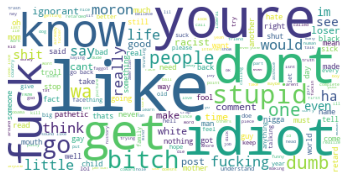

In [35]:
# define the stop words so they do not affect the final wordcloud
stop_words = nltk.corpus.stopwords.words('english')
# generate the wordcloud of our data
insult_wordcloud = WordCloud(max_words=300, background_color="white", stopwords=stop_words).generate(' '.join(train_df.loc[train_df['Insult'] == 1]['Comment'].tolist()))
plt.imshow(insult_wordcloud)
plt.axis('off')
plt.show()

Well, the results are clear, and absolutely NSFW. We are going to remove some curse words from our train dataset, if the comment is not indeed bad, so we do not trick the classifier

In [36]:
curse_words = ['fuck', 'bitch', 'idiot', 'dumb', 'fucking', 'moron', 'stupid', 'racist', 'ass', 'shut', 'looser', 'faggot']

Oh, btw, add Lebron and the Knicks to the curse_words, because no one ever says anything good about them

In [37]:
curse_words.append('lebron')
curse_words.append('knicks')

In [38]:
def censor(row, insult):
    if insult:
        return row
    
    for word in curse_words:
        if word in row:
            row.replace(word,"")
    return row

In [39]:
train_df['Censored_comment'] = train_df.apply(lambda x: censor(x['Comment'], x['Insult']), axis = 1)

### Feature extraction

#### Comment length

Next, let's see the usual length of a insulting commment, in comparison to a neutral one

In [40]:
train_df['comment_length'] = train_df.Comment.apply(lambda row : len(row))
test_df['comment_length'] = test_df.Comment.apply(lambda row : len(row))

train_df.head()

,Insult,Date,Comment,noun%,verb%,adverb%,adjectives%,Censored_comment,comment_length
0,1,20120618192155Z,you fuck your dad,25.0,25.0,0.0,0.0,you fuck your dad,17
1,0,20120528192215Z,i really dont understand your point it seems t...,26.7,26.7,6.7,6.7,i really dont understand your point it seems t...,81
2,0,20120619094753Z,cc b xu bi txecnh 2011 c n ho khng ncc ng dn n...,71.2,4.5,0.0,19.7,cc b xu bi txecnh 2011 c n ho khng ncc ng dn n...,247
3,0,20120620171226Z,sdl ok but i would hope theyd sign him to a on...,16.7,14.6,2.1,16.7,sdl ok but i would hope theyd sign him to a on...,232
4,0,20120503012628Z,yeah and where are you now,16.7,16.7,16.7,0.0,yeah and where are you now,26


train_df.hist(column='comment_length', by='Insult', bins=50, figsize=(12,4))

As we see, the length is almost identical, thus it will not help as at all with our classification

#### Comments containing '@'

As we know, `@` is the symbol for swearing, so see if a word contains a @, and create a new column to store this info

In [41]:
def at(row):
    if '@' in row:
        return 1
    else:
        return 0

In [42]:
train_df['@'] = train_df.Comment.apply(lambda row : at(row))
test_df['@'] = test_df.Comment.apply(lambda row : at(row))

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#### TF-IDF Method

Once again, we are going to use tfidf, but now for the censored comment that we produced

In [43]:
tfidf_vec = TfidfVectorizer()
tfidf_train_vec = tfidf_vec.fit_transform(train_df.Censored_comment)
tfidf_train_data = pd.DataFrame(tfidf_train_vec.toarray())
tfidf_train_data

,0,1,2,3,4,5,6,7,8,9,...,12361,12362,12363,12364,12365,12366,12367,12368,12369,12370
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
tfidf_vec_test = tfidf_vec.transform(test_df.Comment)
tfidf_test_data = pd.DataFrame(tfidf_vec_test.toarray())
tfidf_test_data

,0,1,2,3,4,5,6,7,8,9,...,12361,12362,12363,12364,12365,12366,12367,12368,12369,12370
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluating our model

We are going to use the tf-idf matrices from before, as well as the `@` info that we gathered

In [45]:
final_train_data = pd.concat([train_df['@'], tfidf_train_data], axis=1)
final_test_data = pd.concat([test_df['@'], tfidf_test_data], axis=1)
final_train_data

,@,0,1,2,3,4,5,6,7,8,...,12361,12362,12363,12364,12365,12366,12367,12368,12369,12370
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3224,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3225,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3226,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3227,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We are going to use SVM, so we wan to know the best parameters, that we've allready calculated using `GridSearchCV`

We are going to call svm with those parameters, that are shown below, and hope for the best

In [47]:
clf = SVC(C=1000, gamma=0.001, kernel='rbf')
y_train = train_df.Insult
clf.fit(final_train_data, y_train)
y_pred = clf.predict(final_test_data)

Finally, let's take a look at our scores

In [48]:
y_test = test_df.Insult
# Print the results
print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy is {:.3f}'.format(accuracy))

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      1158
           1       0.75      0.58      0.65      1077

    accuracy                           0.70      2235
   macro avg       0.71      0.70      0.70      2235
weighted avg       0.71      0.70      0.70      2235

Accuracy is 0.704


In [49]:
from sklearn.metrics import f1_score
f1_score(y_test , y_pred, average='micro')

0.7042505592841163

As we can see, those are the best results that we can achieve. The previous best accuracy using SVM was `0.677` so, as we can see, we've kinda beat the benchmark